In [0]:
import xml.dom.minidom as xmldom

In [0]:
import xml.etree.ElementTree as ET

In [0]:
import os

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/"

 articles-test-byarticle.txt  'Getting started.pdf'   model
'Colab Notebooks'	       hyperpartisan


In [0]:
train_xml = os.path.abspath("./drive/My Drive/hyperpartisan/ground-truth-training-bypublisher.xml")
test_xml = os.path.abspath("./drive/My Drive/hyperpartisan/ground-truth-test-byarticle.xml")

In [0]:
train_tree = ET.parse(train_xml)
train_root = train_tree.getroot()

train_label_pos_dict = {}
train_label_neg_dict = {}
for child in train_root:
    if child.attrib['hyperpartisan'] == 'true':
        train_label_pos_dict[child.attrib['id']] = 'true'
    else:
        train_label_neg_dict[child.attrib['id']] = 'false'

In [0]:
test_tree = ET.parse(test_xml)
test_root = test_tree.getroot()

test_label_pos_dict = {}
test_label_neg_dict = {}
for child in test_root:
    if child.attrib['hyperpartisan'] == 'true':
        test_label_pos_dict[child.attrib['id']] = 'true'
    else:
        test_label_neg_dict[child.attrib['id']] = 'false'

In [0]:
train_f = open("./drive/My Drive/hyperpartisan/articles-training-bypublisher.txt")

train_sentence_dict = {}
for line in train_f:
    _id,sent = line.split("\t")
    if _id in train_sentence_dict.keys():
        train_sentence_dict[_id].append(sent.rstrip())
        continue;
    train_sentence_dict[_id] = [sent.rstrip()]

In [0]:
test_f = open("./drive/My Drive/hyperpartisan/articles-test-byarticle.txt")
test_sentence_dict = {}
for line in test_f:
    _id,sent = line.split("\t")
    if _id in test_sentence_dict.keys():
        test_sentence_dict[_id].append(sent.rstrip())
        continue;
    test_sentence_dict[_id] = [sent.rstrip()]
    

In [0]:
#build subset
from random import sample

y_pos_train = sample(list(train_label_pos_dict),150000)
y_neg_train = sample(list(train_label_neg_dict),150000)

In [0]:
y_pos_test = list(test_label_pos_dict)
y_neg_test = list(test_label_neg_dict)

In [0]:
x_pos_train_list = []
x_neg_train_list = []
for _id in y_pos_train:
    x_pos_train_list.append(" ".join(train_sentence_dict[_id]))
for _id in y_neg_train:
    x_neg_train_list.append(" ".join(train_sentence_dict[_id]))

In [0]:
#print(len(test_label_pos_dict))
#print(list(test_sentence_dict.items())[0:14])

In [0]:
x_pos_test_list = []
x_neg_test_list = []
for _id in y_pos_test:
    x_pos_test_list.append(" ".join(test_sentence_dict[_id]))

for _id in y_neg_test:
    x_neg_test_list.append(" ".join(test_sentence_dict[_id]))

In [0]:
print(len(x_pos_test_list))
print(len(x_neg_train_list))

238
150000


In [0]:
x_train = x_pos_train_list + x_neg_train_list

In [0]:
y_train = [1] * len(y_pos_train)
y_train += [0] * len(y_neg_train)

In [0]:
x_test = x_pos_test_list + x_neg_test_list

In [0]:
y_test = [1] * len(y_pos_test)
y_test += [0] * len(y_neg_test)

In [0]:
import time

In [0]:
# gensim modules
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

# numpy
import numpy as np

# classifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import logging
import sys
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
import gensim

In [0]:


def labelizeReviews(articles, label_type):
    for i,v in enumerate(articles):
        label = '%s_%s'%(label_type,i)
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(v,max_len=100), [label])

x_train_tag = list(labelizeReviews(x_train, 'train'))
x_test_tag = list(labelizeReviews(x_test, 'test'))


In [0]:
size = 100
# 实例化 DM 和 DBOW 模型
#log.info('D2V')
model_dm = gensim.models.Doc2Vec(min_count=1, window=10, vector_size=size, sample=1e-3, negative=5, workers=3,epochs=10)
model_dbow = gensim.models.Doc2Vec(min_count=1, window=10, vector_size=size, sample=1e-3, negative=5, dm=0, workers=3,epochs=10)
# 对所有评论创建词汇表
alldata = x_train_tag
alldata.extend(x_test_tag)
#alldata.extend(unsup_reviews_tag)
model_dm.build_vocab(alldata)
model_dbow.build_vocab(alldata)
def sentences_perm(sentences):
    shuffled = list(sentences)
    random.shuffle(shuffled)
    return (shuffled)

In [0]:
model_dm.save('./drive/My Drive/hyperpartisan/model_dm.model')
model_dbow.save('./drive/My Drive/hyperpartisan/model_dbow.model')

NameError: ignored

In [0]:
import random

In [0]:
for epoch in range(9):
    print('EPOCH: {}'.format(epoch))
    model_dm.train(sentences_perm(alldata),total_examples=model_dm.corpus_count,epochs=1)
    model_dbow.train(sentences_perm(alldata),total_examples=model_dbow.corpus_count,epochs=1)

EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4
EPOCH: 5
EPOCH: 6
EPOCH: 7
EPOCH: 8


In [0]:
model_dm.save('./drive/My Drive/hyperpartisan/model/9epoch_model_dm.model')
model_dbow.save('./drive/My Drive/hyperpartisan/model/9epoch_model_dbow.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
model_dm = gensim.models.Doc2Vec.load('./drive/My Drive/hyperpartisan/model_b_train/model_dm.model')
model_dbow = gensim.models.Doc2Vec.load('./drive/My Drive/hyperpartisan/model_b_train/model_dbow.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
import numpy
#第一种方法
train_arrays_dm = numpy.zeros((len(x_train), 100))
train_arrays_dbow = numpy.zeros((len(x_train), 100))
for i in range(len(x_train)):
    tag = 'train_' + str(i)
    train_arrays_dm[i] = model_dm.docvecs[tag]
    train_arrays_dbow[i] = model_dbow.docvecs[tag]
train_arrays = np.hstack((train_arrays_dm, train_arrays_dbow))
test_arrays_dm = numpy.zeros((len(x_test), 100))
test_arrays_dbow = numpy.zeros((len(x_test), 100))
for i in range(len(x_test)):
    tag = 'test_' + str(i)
    test_arrays_dm[i] = model_dm.docvecs[tag]
    test_arrays_dbow[i] = model_dbow.docvecs[tag]
test_arrays = np.hstack((test_arrays_dm, test_arrays_dbow))

NameError: ignored

In [0]:
import sklearn
svm_clf=sklearn.svm.SVC(kernel="linear",gamma='auto')
svm_clf.fit(train_arrays,y_train)
y_dev_pre = svm_clf.predict(test_arrays)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_dev_pre))

In [0]:
classifier = LogisticRegression()
classifier.fit(train_arrays, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

y_dev_pre = classifier.predict(test_arrays)
print(classifier.score(test_arrays, y_test))
y_prob = classifier.predict_proba(test_arrays)[:,1]

0.49147286821705427


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_dev_pre))

              precision    recall  f1-score   support

           0       0.85      0.24      0.37       407
           1       0.42      0.93      0.57       238

    accuracy                           0.49       645
   macro avg       0.63      0.58      0.47       645
weighted avg       0.69      0.49      0.44       645



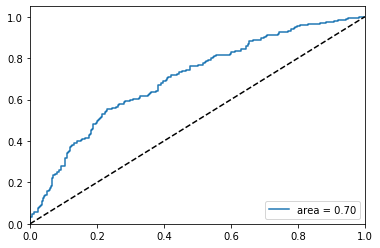

In [0]:

fpr,tpr,_ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label=('area = %.2f')%roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')